In [1]:
train_model = True  # Set true if you want to train the model

In [2]:
import requests
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import date
import datetime
from scipy.integrate import solve_ivp
from scipy import integrate, optimize
import numpy as np
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import arviz as az
import theano

/home/tommi/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Some country codes

###############################
country_name = "Austria"
countrycode = "Q86847911"
population = 8850000
school_closure = date(2020, 3, 16)

###############################
#country_name = "Finland"
#countrycode = "Q84055415"
#population = 5500000
#school_closure = date(2020, 3, 18) 

###############################
#country_name = "Germany"
#countrycode = "Q83889294"
#population = 83000000
#school_closure = date(2020, 3, 13) 

###############################
#country_name = "Greece"
#countrycode = "Q84055415"
#population = 10700000
#school_closure = date(2020, 3, 11) 

###############################
#country_name = "Italy"
#countrycode = "Q84104992"
#population = 60360000
#school_closure = date(2020, 3, 4) 

###############################
#country_name = "Netherlands"
#countrycode = "Q86756826"
#population = 17000000
#school_closure = date(2020, 3, 16) 

###############################
#country_name = "Portugal"
#countrycode = "Q86948603"
#population = 10300000
#school_closure = date(2020, 3, 16) 

###############################
#country_name = "Spain"
#countrycode = "Q84166704"
#population = 47000000
#school_closure = date(2020, 3, 16) 

###############################
#country_name = "United Kingdom"
#countrycode = "Q84167106"
#population = 67000000
#school_closure = date(2020, 3, 20) 


In [4]:
# Define the lengths of different timeperiods: len_timeperiod1 = time interval after school closure,
# len_timeperiod1 = time interval after that
len_timeperiod1 = 14
len_timeperiod2 = 14

# Fixed parameters of the model
D_e = 5.2
D_i = 2.3
D_q = 7
D_h = 30
alpha =  1

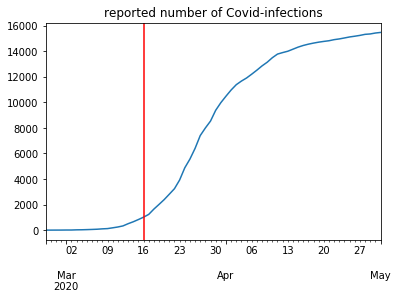

In [5]:
# Clean the wikidata

url = 'https://query.wikidata.org/sparql'
query = """
SELECT
  ?nrcases ?timepoint
WHERE {
 wd:%s p:P1603 ?p .
  ?p pq:P585 ?timepoint ;
     ps:P1603 ?nrcases .
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
""" % (countrycode)

r = requests.get(url, params={'format': 'json', 'query': query}) #execute the query
data = r.json()

cases = []
#cleans the data because some values are missing
for item in data['results']['bindings']:
    cases.append(OrderedDict({'time': item['timepoint']['value'],
'nrcases': item['nrcases']['value']
}))
    
df_wikidata=pd.DataFrame(cases)
#print(df_wikidata['time'].values)



dates = df_wikidata['time'].values
cases = df_wikidata['nrcases'].values

for ind in list(range(len(cases))): 
    cases[ind] = int(cases[ind])
    dates[ind] = datetime.datetime.strptime(dates[ind],"%Y-%m-%dT%H:%M:%SZ")

    
    
zipped_list = list(zip(dates, cases))
zipped_list.sort(key=lambda tup: tup[0])

dates = []
cases = []
for i in zipped_list:
   dates.append(i[0])
   cases.append(i[1])
    
ts = pd.Series(cases,dates)
ts = ts.resample('D').mean()
ts = ts.interpolate()
ts = ts.astype('int64')

ts.plot(title="reported number of Covid-infections")
plt.axvline(school_closure, color='r')

In [6]:
# Create vectors for newly infected cases and calculate initial values for SEIR-function

# Find the correct index for school closure
shutdown_ind = 0
for i in range(len(ts.values)):
    if ts.index[i] == school_closure:
        shutdown_ind = i
                
# obs_cum are the observed cumulative cases 
obs_cum = ts.values[shutdown_ind: shutdown_ind + len_timeperiod1 + len_timeperiod2]

# obs_new is a list of observed daily new cases 
obs_new = obs_cum.copy()
ind = len(obs_new) - 1
while ind >= 1:
    obs_new[ind] = obs_cum[ind] - obs_cum[ind-1]
    ind = ind - 1
obs_new[0] = obs_cum[0] - ts.values[shutdown_ind -1]


# Timelines used for the SEIR-model
timeline1 = np.arange(0, len_timeperiod1)
total_timeline = np.arange(len_timeperiod1 + len_timeperiod2 )
    # the substraction - 1 because of the change point

N = population 

# Initial stages
exp0 = obs_cum[6] - obs_cum[1]
inf0 = obs_cum[0]
asy0 = obs_cum[0]
sus0 = N - exp0 - inf0 -asy0
hos0 = 0

In [7]:
# SEIR-model itself

# y[0]: S, y[1]: E, y[2]: I, y[3]: A, y[4]: H, y[5]: R
# p[0]: beta, p[1]: r, p[2]: alpha
def SEIR(y, t, p):
    ds = -p[0] * y[0] * (y[2] + p[2] * y[3]) / N
    de =  p[0] * y[0] * (y[2] + p[2] * y[3]) / N - y[1] / D_e
    di =  p[1] * y[1] / D_e - y[2] / D_q - y[2] / D_i
    da =  (1 - p[1]) * y[1] / D_e - y[3] / D_i
    dh =  y[2] / D_q - y[4] / D_h
    return [ds, de, di, da, dh]  

In [8]:
# There is one seir_model for each timeline

seir_model = DifferentialEquation(
    func=SEIR,
    times=timeline1,
    n_states=5, # S, E, I, A, H. (no need to have R)
    n_theta=3,
    t0=0,
)

In [9]:
with pm.Model() as modelSIR:
    
    # Parameters that need to be estimated
    beta =  pm.Uniform('beta', 0.2, 6)
    r =  pm.Uniform('r', 0, 1)

    # Reproduction number can be estimated based on beta_i
    R0 = pm.Deterministic('R0', D_i*beta)
    
    lambda_ = r * seir_model(y0 = [sus0, exp0, inf0, asy0, hos0], theta=[beta,r,alpha,])[: ,1] / D_e
        
    new_infectious = pm.Poisson('new_infectious', lambda_ , observed = obs_new[0:len_timeperiod1])

In [10]:
# Either train the model or use data based on previous trainings

save_as = "%s_seiahr_no_combine" % (country_name)

if train_model:
    with modelSIR:
        trace = pm.sample(500,tune=500, target_accept = 0.95, cores=1)
        db = pm.backends.Text(save_as)
        pm.save_trace(trace, directory = save_as, overwrite=True)
else:
    with modelSIR:
        trace = pm.load_trace(directory = save_as)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [r, beta]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [8:54:03<00:00, 32.04s/it]   
The estimated number of effective samples is smaller than 200 for some parameters.


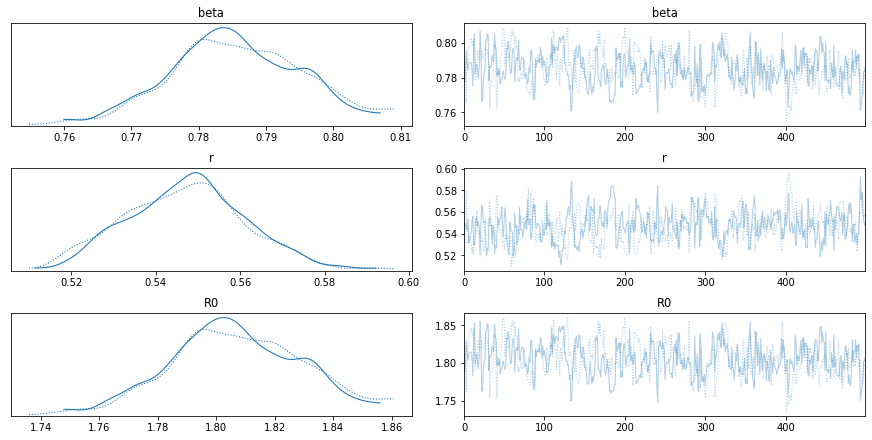

In [11]:
# Plot posterior distributions for beta1, beta2, r1 and r2
pm.traceplot(trace);

In [12]:
pm.summary(trace).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,0.785,0.010,0.768,0.804,0.001,0.001,174.0,174.0,174.0,339.0,1.03
r,0.547,0.014,0.522,0.574,0.001,0.001,179.0,179.0,177.0,273.0,1.03
R0,1.806,0.022,1.767,1.849,0.002,0.001,174.0,174.0,174.0,339.0,1.03


In [16]:
# This cell defines a slightly modified SEIR-model that will also count the cumulative number of infected 
# by adding one extra state. The old SEIR-model(s) won't work because in there infected will get healthy
# and not remain always infected

beta_estimated = np.mean(trace.beta)
r_estimated = np.mean(trace.r)

def SEIR_cum(y, t, p):
    ds = -p[0] * y[0] * (y[2] + p[2] * y[3]) / N
    de =  p[0] * y[0] * (y[2] + p[2] * y[3]) / N - y[1] / D_e
    di =  p[1] * y[1] / D_e - y[2] / D_q - y[2] / D_i
    da =  (1 - p[1]) * y[1] / D_e - y[3] / D_i
    dh =  y[2] / D_q - y[4] / D_h
    
    dcum_i = p[1] * y[1] / D_e  # cumulative number of infected
    
    return [ds, de, di, da, dh, dcum_i]  



# Solve the first timeline

dcum_i_0 = 0 # set counter to 0

y1 = odeint(SEIR_cum, t=total_timeline, y0=[sus0, exp0, inf0, asy0, hos0, dcum_i_0],
           args=((beta_estimated ,r_estimated,alpha,),), rtol=1e-8)

dcum_total = y1[:,5]

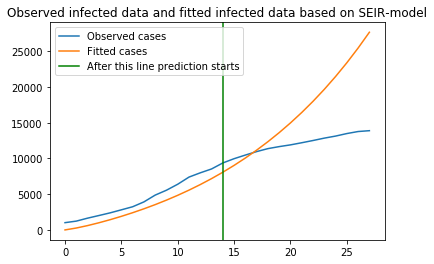

In [17]:
# Plot observed cumulative infected and the amount of newly infected based on SEIR-model

observed_inf = plt.plot(total_timeline, obs_cum, label='Observed cases')

model_inf = plt.plot(total_timeline, dcum_total, label = "Fitted cases")

prediction_starts = plt.axvline(len_timeperiod1, color='g',label ="After this line prediction starts")

plt.title("Observed infected data and fitted infected data based on SEIR-model")
plt.legend(loc="upper left")
plt.show()